In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries and imports

In [2]:
!pip install huggingface_hub
!pip install sae_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [29]:
import huggingface_hub
from sae_lens import SAE
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame

# Constants

In [4]:
DATA_PATH = "./drive/MyDrive/University/CoT/experimental_data/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data

In [18]:
acts_resid = torch.load(DATA_PATH + "acts_resid.pt")
acts_exp_resid = torch.load(DATA_PATH + "acts_exp_resid.pt")
diff_resid = torch.load(DATA_PATH + "diffs_resid.pt")

<ipython-input-18-6ea75a52f633>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts_resid = torch.load(DATA_PATH + "acts_resid.pt")
<ipython-input-18-6ea75a52f633>:2: Futu

In [19]:
print(acts_resid.shape)
print(acts_exp_resid.shape)
print(diff_resid.shape)

torch.Size([100, 26, 2304])
torch.Size([100, 26, 2304])
torch.Size([100, 26, 2304])


# Load SAE

In [7]:
sae, cfg, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = "layer_25/width_16k/canonical",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

# Look at the activations to decide which feature to look at

In [32]:
std_exp_resid = torch.std(acts_exp_resid, dim=0)
std_resid = torch.std(acts_resid, dim=0)
std_diffs_resid = torch.std(diff_resid, dim=0)
mean_exp_resid = torch.mean(acts_exp_resid, dim=0)
mean_resid = torch.mean(acts_resid, dim=0)
mean_diffs_resid = torch.mean(diff_resid, dim=0)

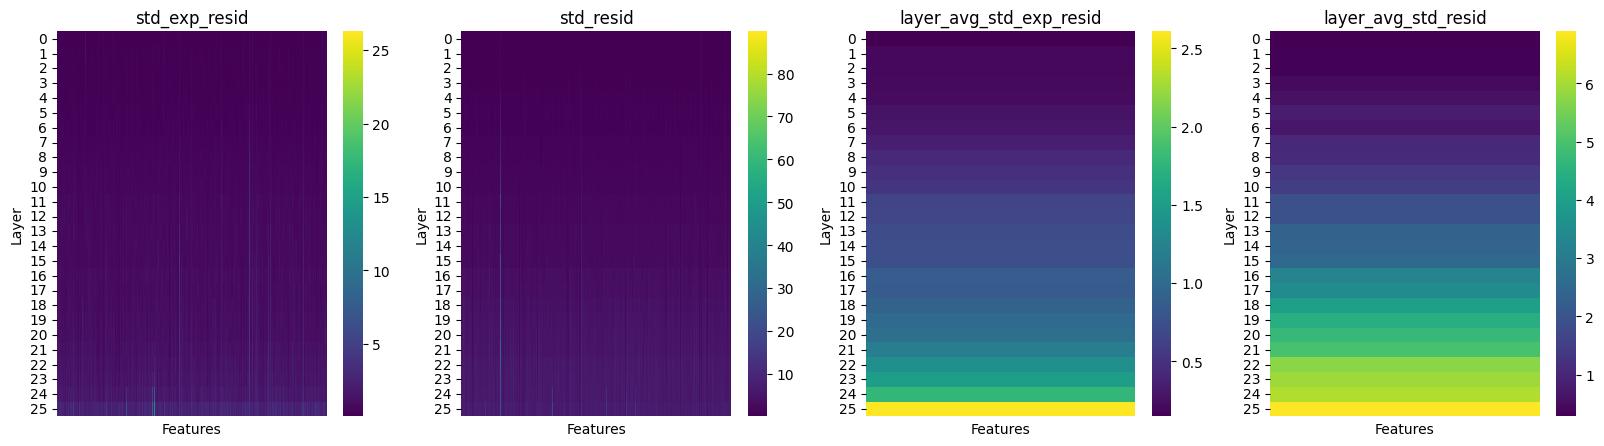

In [21]:
def draw_heatmap(tensor: torch.Tensor, title: str, axis=None):
    """
    Draws a heatmap of the tensor.
    args:
        tensor: The tensor to draw the heatmap of. Must have dimensionality of 2
        title: The title of the heatmap.
        axis: The axis to draw the heatmap on (for side-by-side plots), default to None if not needed
    """
    data = tensor.to(torch.float32).cpu().numpy()
    sns.heatmap(data, cmap='viridis', cbar=True, xticklabels=False, yticklabels=True, ax=axis)

    ax = axis if axis is not None else plt.gca()
    ax.set_xlabel('Features')
    ax.set_ylabel('Layer')
    ax.set_title(title)

layer_avg_std_exp_resid = torch.mean(std_exp_resid, dim=1).unsqueeze(1)
layer_avg_std_resid = torch.mean(std_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
draw_heatmap(std_exp_resid, "std_exp_resid", axes[0])
draw_heatmap(std_resid, "std_resid", axes[1])
draw_heatmap(layer_avg_std_exp_resid, "layer_avg_std_exp_resid", axes[2])
draw_heatmap(layer_avg_std_resid, "layer_avg_std_resid", axes[3])
plt.show()

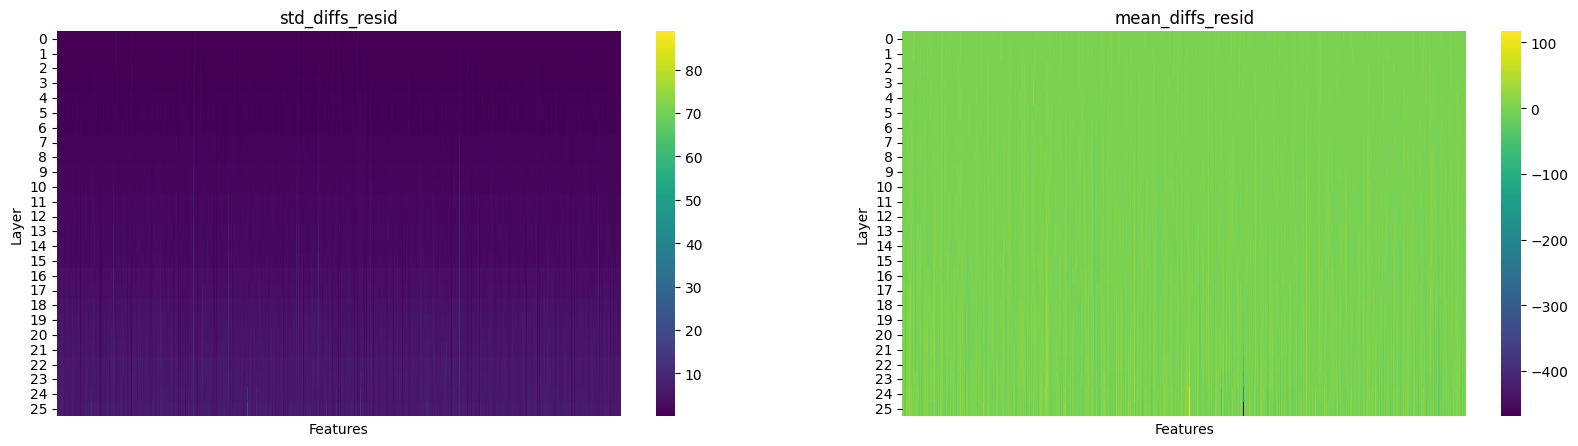

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
draw_heatmap(std_diffs_resid, "std_diffs_resid", axis=axes[0])
draw_heatmap(mean_diffs_resid, "mean_diffs_resid", axis=axes[1])
plt.show()

There seems to be a very high std neuron in the last layer with CoT. Let's take a look at it.

In [36]:
def get_max_indeces(input: torch.Tensor, k: int):
    """
    Gets the indices of the maximum elements for each layer.
    args:
        input: The standard deviation of the activations.
        k: Top k maximum standard deviations to return.
    returns:
        The indices of the maximum standard deviation for each layer.
    """
    indeces = []
    for i in range(input.shape[0]):
        indeces_layer_i = torch.argsort(input[i, :], dim=0, descending=True)[:k]
        indeces.append(indeces_layer_i)
    indeces = torch.stack(indeces)
    return indeces

cot_exp_indeces = get_max_indeces(std_exp_resid, 1)
cot_diffs_indeces = get_max_indeces(mean_diffs_resid, 1)

In [37]:
print(cot_diffs_indeces)
print(torch.gather(mean_diffs_resid, 1, cot_diffs_indeces))

tensor([[1546],
        [1546],
        [1546],
        [ 535],
        [ 535],
        [ 533],
        [ 334],
        [1570],
        [ 334],
        [ 334],
        [1645],
        [1645],
        [1645],
        [1570],
        [1651],
        [1570],
        [ 334],
        [1570],
        [ 334],
        [ 334],
        [1570],
        [ 334],
        [ 334],
        [1173],
        [1173],
        [1173]], device='cuda:0')
tensor([[ 17.3388],
        [ 16.6816],
        [ 13.4469],
        [ 17.2391],
        [ 18.4171],
        [ 15.7499],
        [ 24.2515],
        [ 14.9422],
        [ 23.0380],
        [ 27.0618],
        [ 23.9037],
        [ 24.9395],
        [ 24.4055],
        [ 21.5788],
        [ 23.1461],
        [ 27.7131],
        [ 32.7769],
        [ 35.4246],
        [ 62.8837],
        [ 59.4611],
        [ 39.6866],
        [ 81.3773],
        [ 63.1123],
        [ 47.0121],
        [ 97.6254],
        [116.7314]], device='cuda:0')


# Look at the activation via SAE

In [44]:
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

layer = 20
feature_index = 1570

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    """
    Gets the html for the dashboard of gemma interpretation
    args:
        sae_release: The release of the SAE. Should be of the form "gemma-2-2b".
        sae_id: The id of the SAE. Should be of the form "<layer>-<SAE name>-<stream>-<scale>"
        feature_idx: The index of the feature to look at.
    """
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id=f"{layer}-gemmascope-res-16k", feature_idx=feature_index)
IFrame(html, width=1200, height=600)